In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from cb import curlyBrace
from statistics_plot import boxplot, bar_and_kde, log_bar
from statistics_calc import calc_cohens_d, calc_ttest_df
from statistics_calc import perform_kruskal, perform_bartlett, perform_ttest, perform_mann_whitney_u
from statistics_calc import parse_significance, parse_pval, strfnumber, strfint, print_median, print_mean, print_IQR, print_CI

import watermark

plt.style.use('./personal.mplstyle')
tab10 = plt.get_cmap("tab10").colors

%matplotlib inline
%load_ext watermark
%watermark -n -v -m -g -iv

_COHORTS = ["A", "D"]
_LABELS = {"A": r"$A$", "D": r"$D$"}
_DEMO = {"individual": r"individual", "male": r"male", "female": r"female", 
         "<=18": r"18 and below", "19-29": r"19-29", "30-39": r"30-39", ">=40": r"40 and up"}
_COLORS = {"A": tab10[2], "D": tab10[0]}
_FILT_DATE = pd.Timestamp("1 January 2018", tz="UTC")
_TIME_FORMAT = "%Y-%m-%d %H:%M:%S %Z"

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 

watermark : 2.3.0
numpy     : 1.24.3
pandas    : 1.4.2
matplotlib: 3.5.1



# Loading all information

Determine the users that are contained in the $A$ and $D$ cohorts.

In [2]:
demo_groups = pd.read_csv("data/demographic_group_membership.tsv", sep="\t", index_col="user_id")
diag_groups = pd.read_csv("data/diagnosis_group_membership.tsv", sep="\t", index_col="user_id")
membership = diag_groups[diag_groups.any(axis=1)]
cohorts = {"D": membership[membership["group_depression"]].index, "A": membership[membership["group_anxiety"]].index}

Load all VADER scores extracted from the tweets

In [3]:
T = pd.read_csv("data/VADER_scores.tsv.gz", sep="\t", index_col="tweet_id")
T["created_at"] = pd.to_datetime(T["created_at"])
time_filt = T.created_at >= _FILT_DATE
scores = {v: T[T.user_id.isin(cohorts[v]) & time_filt] for v in _COHORTS}

Calculate the per user statistics for both the VADER scores and activity.

In [4]:
pu = {v: scores[v].groupby("user_id") for v in _COHORTS}
user_avg = {}
user_std = {}
user_act = {v: pu[v].count()["created_at"] / (pu[v].max()["created_at"] - pu[v].min()["created_at"]).dt.days for v in _COHORTS}
for v in _COHORTS:
    user_avg[v] = pu[v].mean()["VADER_NEG"]
    user_std[v] = pu[v].std()["VADER_NEG"]

Determine the demographic distribution of our both cohorts and the comorbid cohort (which we exclude from the analysis)

In [5]:
idx = ["{} cohort".format(_LABELS[c]) for c in _COHORTS] + ["$C$ cohort", "Total"]
demo_dist = pd.DataFrame(index=idx, columns=_DEMO.values())

group = {"A": "group_anxiety", "D": "group_depression"}
groups = [group[c] for c in _COHORTS]
for d in _DEMO:
    for c in _COHORTS:
        cnt = (membership[group[c]] & demo_groups[d] & demo_groups["individual"]).sum()
        demo_dist.loc["{} cohort".format(_LABELS[c]), _DEMO[d]] = "{:d}".format(cnt)
        
    C_cnt = (membership["comorbid"] & demo_groups[d] & demo_groups["individual"]).sum()
    demo_dist.loc["$C$ cohort", _DEMO[d]] = "{:d}".format(C_cnt)
        
    total = (demo_groups[d] & demo_groups["individual"] & (membership[groups].sum(axis=1) > 0)).sum()
    demo_dist.loc["Total", _DEMO[d]] = "{:d}".format(total)

Loading the bootstrap samples.

In [6]:
samples = {
    "D": pd.read_csv("data/bootstrap_samples_D.tsv.gz", compression="gzip", sep="\t", index_col=0), 
    "A": pd.read_csv("data/bootstrap_samples_A.tsv.gz", compression="gzip", sep="\t", index_col=0)
}

# Data for the paper

This section prints all information that should be copied to the paper.

## Abstract

In [7]:
a = demo_dist.loc["Total", "individual"]
b = demo_dist.loc["$A$ cohort", "individual"]
c = demo_dist.loc["$D$ cohort", "individual"]

MWU = perform_mann_whitney_u(user_std["A"], user_std["D"])
cohens_d = strfnumber(calc_cohens_d(user_std["A"], user_std["D"]))
sign = parse_significance(perform_mann_whitney_u(user_std["A"], user_std["D"], strfy=False)[0].pvalue)
d = "${}$, {}, $d={}$".format(sign, MWU, cohens_d)

MWU = perform_mann_whitney_u(user_avg["A"], user_avg["D"])
cohens_d = strfnumber(calc_cohens_d(user_avg["A"], user_avg["D"]))
sign = parse_significance(perform_mann_whitney_u(user_avg["A"], user_avg["D"], strfy=False)[0].pvalue)
e = "${}$, {}, $d={}$".format(sign, MWU, cohens_d)

print("""{} individuals
$A$ cohort, $n={}$
$D$ cohort, $n={}$
{}
{}""".format(a,b,c,d,e))

1853 individuals
$A$ cohort, $n=896$
$D$ cohort, $n=957$
$^{***}$, $U=367210, p<.001, r=0.14$, $d=0.25$
$^{***}$, $U=377368, p<.001, r=0.12$, $d=0.21$


## Methods

### Data Gathering

In [8]:
a = demo_dist.loc["Total", "individual"]
b = scores["A"].index.union(scores["D"].index).size

c = min([scores[c].created_at.min() for c in _COHORTS]).strftime("%B %d %Y")
d = max([scores[c].created_at.max() for c in _COHORTS]).strftime("%B %d %Y")

num_diag = membership[[c for c in membership.columns if c not in ["group_depression", "group_anxiety", "comorbid"]]].sum()
e = "\n".join(["{}{}".format(k.ljust(20, " "),v) for k,v in list(num_diag.items()) + [("Total", membership.index.size)]])

print("""$n={}$
$N={}$
between {} and {}
Table 1: Diagnoses number overview:
{}""".format(a,b,c,d,e))

$n=1853$
$N=2492480$
between January 01 2018 and July 08 2020
Table 1: Diagnoses number overview:
phobia              11
dysthymia           15
SAD                 8
panic               69
agoraphobia         16
PDD                 2
OCD                 237
GAD                 168
anxiety             1098
depression          1474
Total               2389


### Cohort Construction

In [9]:
a = demo_dist.loc["$C$ cohort", "individual"]
b = demo_dist.loc["$A$ cohort", "individual"]
c = demo_dist.loc["$D$ cohort", "individual"]

print("""Comorbid: {} individuals
$A$ cohort, $n={}$
$D$ cohort, $n={}$""".format(a,b,c))

Comorbid: 536 individuals
$A$ cohort, $n=896$
$D$ cohort, $n=957$


### Demographic Information

In [10]:
demo_dist.loc[["$A$ cohort", "$D$ cohort", "Total"], :]

,individual,male,female,18 and below,19-29,30-39,40 and up
$A$ cohort,896,215,543,205,249,97,55
$D$ cohort,957,277,504,225,232,91,72
Total,1853,492,1047,430,481,188,127


### Sentiment analysis as an indicator of affect

In [11]:
VADER = SentimentIntensityAnalyzer()
examples = ["Gloomy day, only despair and disappointment.", "Embracing beauty, surrounded by joy and love."]
for ex in examples:
    print("{:50s}: {}".format(ex, str(VADER.polarity_scores(ex))))
# {ex: VADER.polarity_scores(ex) for ex in examples}

Gloomy day, only despair and disappointment.      : {'neg': 0.706, 'neu': 0.294, 'pos': 0.0, 'compound': -0.7351}
Embracing beauty, surrounded by joy and love.     : {'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'compound': 0.9153}


## Results
### Similar online activity levels of $A$ and $D$ cohort

In [12]:
a = print_median(user_act["A"])
b = print_median(user_act["D"])
c = perform_mann_whitney_u(user_act["A"], user_act["D"])

print("""{} and {} tweets per day for the $A$ and $D$ cohorts respectively
Mann-Whitney U test ({})""".format(a,b,c))

$Mdn=4.02$ and $Mdn=3.94$ tweets per day for the $A$ and $D$ cohorts respectively
Mann-Whitney U test ($U=441351, p=.273, r=-0.029$)


### Affect levels between $A$ and $D$ cohorts

In [13]:
MWU = perform_mann_whitney_u(user_avg["A"], user_avg["D"])
cohens_d = strfnumber(calc_cohens_d(user_avg["A"], user_avg["D"]))
sign = parse_significance(perform_mann_whitney_u(user_avg["A"], user_avg["D"], strfy=False)[0].pvalue)
a = "${}$, {}, $d={}$".format(sign, MWU, cohens_d)

b = print_mean(user_avg["A"])
c = print_mean(user_avg["D"])

print("""({})
{} and {} for the $A$ and $D$ cohorts, respectively""".format(a,b,c))

($^{***}$, $U=377368, p<.001, r=0.12$, $d=0.21$)
$M=0.083$ and $M=0.089$ for the $A$ and $D$ cohorts, respectively


### Figure 1

Figure 1 Caption: $n=896$ and $n=957$


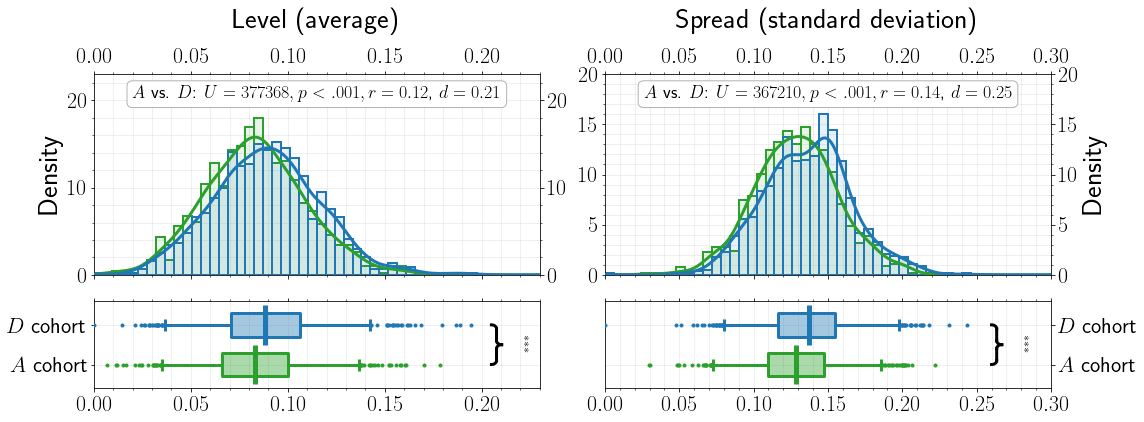

In [14]:
a = demo_dist.loc["$A$ cohort", "individual"]
b = demo_dist.loc["$D$ cohort", "individual"]

print("""Figure 1 Caption: $n={}$ and $n={}$""".format(a,b))

figP = plt.figure(figsize=(16, 6))
gsP = figP.add_gridspec(6, 2)
_DIST_PAPER = {"STD": gsP[:4, 1], "AVG": gsP[:4, 0]}
_BAR_PAPER = {"STD": gsP[4:6, 1], "AVG": gsP[4:6, 0]}
_XLIMSP = {"STD": (0.0, 0.3), "AVG": (0.0, 0.23)}
_YLIMSP = {"STD": 20, "AVG": 23}
_XCB = {"STD": 0.26, "AVG": 0.205}
_TITLESP = {
    "AVG": r"Level (average)",
    "STD": r"Spread (standard deviation)",
    
}
_DATAP = {
    "STD": user_std, 
    "AVG": user_avg
}

for opt in ["AVG", "STD"]:    
    ax = figP.add_subplot(_DIST_PAPER[opt])
    bx = figP.add_subplot(_BAR_PAPER[opt])
    for x, c in enumerate(_COHORTS):
        data = _DATAP[opt][c]
    
        xl, xr = _XLIMSP[opt]

        ax = bar_and_kde(ax, data, xl, xr, step=(xr - xl) / 50, kde_step=0.001, color=_COLORS[c])
        ax.set_xlim(xl, xr)
        ax.set_ylim(0, _YLIMSP[opt])
        ax.tick_params(which="both", top=True, bottom=True, left=True, right=True,
                       labelbottom=False, labeltop=True, labelleft=True, labelright=True)
        bx = boxplot(bx, data, x * 0.5, dash="median", color=_COLORS[c])
        bx.set_xlim(xl, xr)
        bx.tick_params(which="both", top=True, bottom=True, left=(opt=="AVG"), right=(opt=="STD"),
                       labelbottom=True, labeltop=False, labelleft=(opt=="AVG"), labelright=(opt=="STD"))
        bx.yaxis.set_minor_locator(mticker.NullLocator())
        bx.set_yticks([_ * 0.5 for _, c in enumerate(_COHORTS)])
        bx.set_yticklabels(["{} cohort".format(_LABELS[_]) for _ in _COHORTS])

    ax.set_title(_TITLESP["{}".format(opt)], y=1.2)
    ax.set_ylabel(r"Density", fontsize=28)
    if opt == "STD":
        ax.yaxis.set_label_position("right")

    C1 = _DATAP[opt]["A"]
    C2 = _DATAP[opt]["D"]

    AD, r = perform_mann_whitney_u(C1, C2, strfy=False)
    cohens_d = strfnumber(calc_cohens_d(C1, C2))
    sign = "${}$".format(parse_significance(AD.pvalue))
    ADs = "{}, $d={}$".format(perform_mann_whitney_u(C1, C2), cohens_d)
    ax.annotate(r"$A$ vs. $D$: {}".format(ADs), (0.5, 0.94), xycoords="axes fraction",
                size=18, va="top", ha="center", bbox=dict(boxstyle="round", pad=0.3, fc="w", ec="0.7"))

    curlyBrace(figP, bx, (_XCB[opt], 0.5), (_XCB[opt], 0), color="k", str_text=sign, fontdict={"size": 18, "rotation": 90})

figP.tight_layout()
figP.savefig("figures/NA_D_vs_A.pdf", dpi=600)

### Affect variability between $A$ and $D$ cohorts

In [15]:
a = print_mean(user_std["A"])
b = print_mean(user_std["D"])

MWU = perform_mann_whitney_u(user_std["A"], user_std["D"])
cohens_d = strfnumber(calc_cohens_d(user_std["A"], user_std["D"]))
sign = parse_significance(perform_mann_whitney_u(user_std["A"], user_std["D"], strfy=False)[0].pvalue)
c = "${}$, {}, $d={}$".format(sign, MWU, cohens_d)

print("""{} and {} for the $A$ and $D$ cohorts respectively
({})""".format(a,b,c))

$M=0.13$ and $M=0.14$ for the $A$ and $D$ cohorts respectively
($^{***}$, $U=367210, p<.001, r=0.14$, $d=0.25$)


### Variations between individuals

In [16]:
_VARIANTS = {
    "ACTIVITY": user_act,
    "VADER_NEG_AVG": user_avg,
    "VADER_NEG_STD": user_std
}

idx = pd.MultiIndex.from_product([[_ for _ in _VARIANTS], [_LABELS[c] for c in _COHORTS]])
table = pd.DataFrame(index=idx, columns=["median", "CI", "significance"])

for val in _VARIANTS:
    data = _VARIANTS[val]
    
    C1 = data["A"]
    C2 = data["D"]
    
    evar = perform_bartlett(C1, C2, strfy=False).pvalue >= 0.05
    
    AD = perform_ttest(C1, C2, strfy=False, equal_var=evar)
    
    for num, c in enumerate(_COHORTS):
        if val == "ACTIVITY":
            bootstrap = samples[c].apply(lambda col: data[c].loc[col].median())
        else:
            bootstrap = samples[c].apply(lambda col: data[c].loc[col].mean())
            
        table.loc[(val, _LABELS[c]), "median"] = print_median(bootstrap)
        table.loc[(val, _LABELS[c]), "CI"] = print_CI(bootstrap, ntrvl_only=True)
        
        if num == 0:
            table.loc[(val, _LABELS[c]), "significance"] = "${}$".format(parse_significance(AD.pvalue))


table.to_csv("results_table.tex", sep="&")
table

Performing an independent t-test
Performing an independent t-test
Performing an independent t-test


median                CI significance
ACTIVITY      $A$   $Mdn=4.02$    $[3.51, 4.57]$         $ns$
              $D$   $Mdn=3.94$    $[3.37, 4.44]$          NaN
VADER_NEG_AVG $A$  $Mdn=0.083$  $[0.082, 0.085]$     $^{***}$
              $D$  $Mdn=0.089$  $[0.087, 0.091]$          NaN
VADER_NEG_STD $A$   $Mdn=0.13$    $[0.13, 0.13]$     $^{***}$
              $D$   $Mdn=0.14$    $[0.13, 0.14]$          NaN